# Lens modeling of DESIJ1709+3154 with lenstronomy

Author: Tanjela \
Acknowledgement: Nahid

# Import of standard python libraries


In [6]:
import corner
import h5py
import joblib
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
from lenstronomy.Data.coord_transforms import Coordinates
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Util import mask_util, util
from lenstronomy.Util.param_util import ellipticity2phi_q
from lenstronomy.Workflow.fitting_sequence import FittingSequence

%matplotlib inline

In [7]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load imaging data

In [8]:
with h5py.File("/content/DESIJ1709+3154_F140W.h5", "r") as f:
    kwargs_data = {}
    for key in f:
        kwargs_data[key] = f[key][()]

kwargs_data

{'background_rms': 0.012138557566447335,
 'dec_at_xy_0': -5.239999999999995,
 'exposure_time': array([[359.87256, 438.06912, 395.772  , ..., 419.91418, 398.95667,
         412.0478 ],
        [514.854  , 544.1436 , 447.31396, ..., 445.43423, 523.56964,
         512.79553],
        [364.70517, 475.4317 , 416.52582, ..., 455.95795, 477.7484 ,
         507.18954],
        ...,
        [541.16736, 482.96542, 453.8767 , ..., 407.2749 , 408.97824,
         413.95084],
        [452.9683 , 439.0108 , 417.46097, ..., 568.15814, 551.5595 ,
         480.95288],
        [293.528  , 306.62485, 420.6663 , ..., 379.75095, 417.29932,
         444.0264 ]], dtype=float32),
 'image_data': array([[ 0.01424764,  0.006525  ,  0.00161528, ...,  0.04487504,
          0.05846716,  0.05135536],
        [ 0.0089196 , -0.01107989, -0.02504737, ...,  0.03001957,
          0.04486683,  0.0455122 ],
        [ 0.01499274,  0.0155811 ,  0.00463138, ...,  0.01737003,
          0.05439983,  0.05461017],
        ...,
   

In [9]:
with h5py.File("/content/psf_F140W.h5", "r") as f:
    kwargs_psf = {}
    for key in f:
        kwargs_psf[key] = f[key][()]

kwargs_psf["psf_type"] = "PIXEL"
kwargs_psf

{'kernel_point_source': array([[5.7422681e-06, 4.5087054e-06, 2.4900439e-06, ..., 1.8486933e-06,
         3.2385867e-06, 4.4331632e-06],
        [3.9503216e-06, 9.9817180e-06, 6.5966469e-06, ..., 3.9997908e-06,
         6.6143798e-06, 4.1430776e-06],
        [2.9697005e-06, 5.5563592e-06, 1.2795975e-05, ..., 7.8115263e-06,
         5.1404800e-06, 1.7530243e-06],
        ...,
        [1.6921831e-06, 3.7347368e-06, 7.6415899e-06, ..., 1.1465157e-05,
         5.3933368e-06, 1.6360833e-06],
        [2.8819463e-06, 6.2348781e-06, 4.7564718e-06, ..., 4.5906190e-06,
         8.7221979e-06, 3.7005334e-06],
        [3.7170516e-06, 3.6243027e-06, 1.6518559e-06, ..., 2.0127884e-06,
         3.2246478e-06, 5.1252514e-06]], dtype=float32),
 'psf_type': 'PIXEL'}

###Visualizing the data

<ipython-input-10-f3727655582e>:2: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(image_data), origin="lower", cmap="cubehelix")


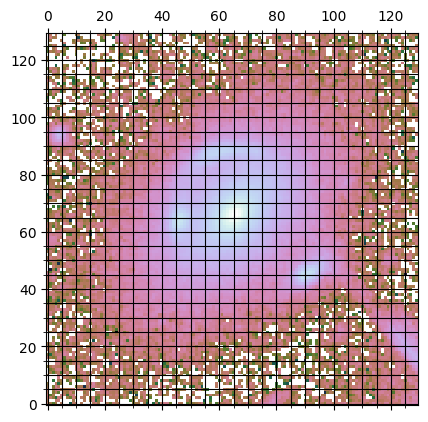

In [10]:
image_data = kwargs_data["image_data"]
plt.matshow(np.log10(image_data), origin="lower", cmap="cubehelix")
plt.grid(which="both", color="black")
plt.minorticks_on()
plt.grid(which="minor", color="black")
plt.show()

## Creating Mask

[[ 5.24  5.16  5.08 ... -4.92 -5.   -5.08]
 [ 5.24  5.16  5.08 ... -4.92 -5.   -5.08]
 [ 5.24  5.16  5.08 ... -4.92 -5.   -5.08]
 ...
 [ 5.24  5.16  5.08 ... -4.92 -5.   -5.08]
 [ 5.24  5.16  5.08 ... -4.92 -5.   -5.08]
 [ 5.24  5.16  5.08 ... -4.92 -5.   -5.08]] [[-5.24 -5.24 -5.24 ... -5.24 -5.24 -5.24]
 [-5.16 -5.16 -5.16 ... -5.16 -5.16 -5.16]
 [-5.08 -5.08 -5.08 ... -5.08 -5.08 -5.08]
 ...
 [ 4.92  4.92  4.92 ...  4.92  4.92  4.92]
 [ 5.    5.    5.   ...  5.    5.    5.  ]
 [ 5.08  5.08  5.08 ...  5.08  5.08  5.08]]


<ipython-input-11-3ce4ec2773b4>:84: RuntimeWarning: invalid value encountered in log10
  ori = np.log10(kwargs_data["image_data"])
<ipython-input-11-3ce4ec2773b4>:86: RuntimeWarning: divide by zero encountered in log10
  masked_img = np.log10(kwargs_data["image_data"] * mask_img)
<ipython-input-11-3ce4ec2773b4>:86: RuntimeWarning: invalid value encountered in log10
  masked_img = np.log10(kwargs_data["image_data"] * mask_img)
<ipython-input-11-3ce4ec2773b4>:89: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(kwargs_data["image_data"]), origin="lower", cmap="cubehelix")


Text(0.5, 1.0, 'Masked image')

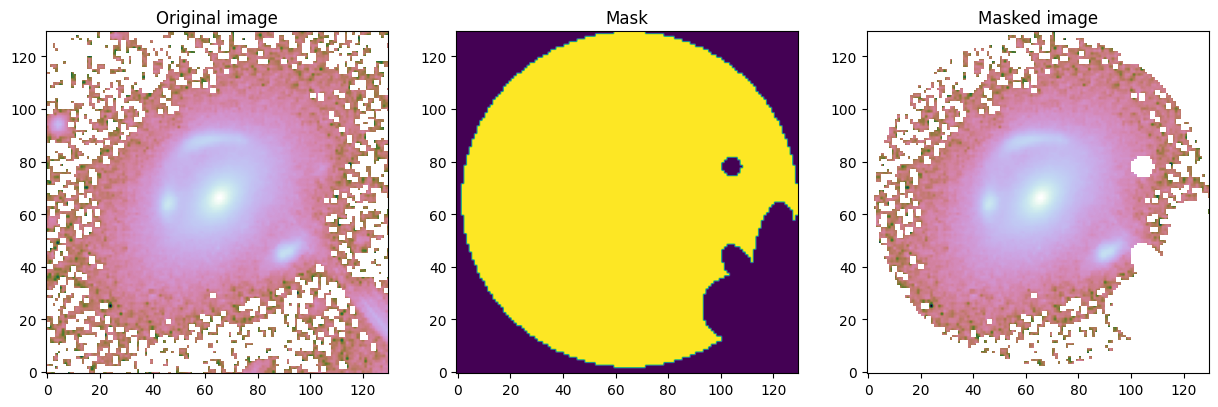

In [11]:
# To make a likelihood mask using lenstronomy functions,
# here is an example code:


ra_at_xy_0 = kwargs_data["ra_at_xy_0"]
dec_at_xy_0 = kwargs_data["dec_at_xy_0"]
transform_pix2angle = kwargs_data["transform_pix2angle"]

coords = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)
num_pix = len(kwargs_data["image_data"])

x_coords, y_coords = coords.coordinate_grid(num_pix, num_pix)

print(x_coords, y_coords)

r = 5.1  # arcseconds
lens_center_ra = 0
lens_center_dec = 0

mask_outer = mask_util.mask_center_2d(
    lens_center_ra,
    lens_center_dec,
    r,
    util.image2array(x_coords),
    util.image2array(y_coords),
)


mask_ext_1 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 3.1,
    lens_center_dec + 1,
    0.3,
    0.3,
    0.0,
)


mask_ext_2 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 3.3,
    lens_center_dec - 2.0,
    0.71,
    0.4,
    45,
)

mask_ext_3 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 3.2,
    lens_center_dec - 3.3,
    1.0,
    1,
    15,
)

mask_ext_4 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 4.4,
    lens_center_dec - 1.6,
    1.55,
    0.6,
    30,
)


mask = (
    (1 - mask_outer)
    * (1 - mask_ext_1)
    * (1 - mask_ext_2)
    * (1 - mask_ext_3)
    * (1 - mask_ext_4)
)

mask_img = mask.reshape(num_pix, num_pix)


fig, axs = plt.subplots(1, 3, figsize=(15, 10))

ori = np.log10(kwargs_data["image_data"])

masked_img = np.log10(kwargs_data["image_data"] * mask_img)

plt.sca(axs[0])
plt.imshow(np.log10(kwargs_data["image_data"]), origin="lower", cmap="cubehelix")
plt.title("Original image")

plt.sca(axs[1])
plt.imshow(mask_img, origin="lower")
plt.title("Mask")

plt.sca(axs[2])
plt.imshow(masked_img, origin="lower", cmap="cubehelix")
plt.title("Masked image")

## Building the lens model

In [12]:
lens_model_list = ["EPL", "SHEAR"]
source_model_list = ["SERSIC_ELLIPSE", "SHAPELETS"]
lens_light_model_list = ["SERSIC_ELLIPSE", "SERSIC_ELLIPSE"]

### Mass model of the lens galaxy

In [13]:
# lens galaxy's mass model
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

# setting EPL parameters
fixed_lens.append({})
kwargs_lens_init.append(
    {
        "theta_E": 1.5,
        "gamma": 2.0,
        "e1": 0.0,
        "e2": 0.0,
        "center_x": 0.0,
        "center_y": 0.0,
    }
)

kwargs_lens_sigma.append(
    {
        "theta_E": 0.2,
        "gamma": 0.1,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.5,
        "center_y": 0.5,
    }
)
kwargs_lower_lens.append(
    {
        "theta_E": 2.0,
        "gamma": 1.5,
        "e1": -0.5,
        "e2": -0.5,
        "center_x": -10,
        "center_y": -10,
    }
)
kwargs_upper_lens.append(
    {
        "theta_E": 10.0,
        "gamma": 3.0,
        "e1": 0.5,
        "e2": 0.5,
        "center_x": 10,
        "center_y": 10,
    }
)

# Setting SHEAR Parameters
fixed_lens.append({"ra_0": 0, "dec_0": 0})

kwargs_lens_init.append({"gamma1": -0.01, "gamma2": -0.01, "ra_0": 0, "dec_0": 0})

kwargs_lens_sigma.append({"gamma1": 0.1, "gamma2": 0.1, "ra_0": 0, "dec_0": 0})
kwargs_lower_lens.append({"gamma1": -0.3, "gamma2": -0.3, "ra_0": -100, "dec_0": -100})
kwargs_upper_lens.append({"gamma1": 0.3, "gamma2": 0.3, "ra_0": 100, "dec_0": 100})

lens_params = [
    kwargs_lens_init,
    kwargs_lens_sigma,
    fixed_lens,
    kwargs_lower_lens,
    kwargs_upper_lens,
]

###Light model of the lens galaxy

In [14]:
# lens galaxy's light model
fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []

# 1st sersic

fixed_lens_light.append({"n_sersic": 1.0})

kwargs_lens_light_init.append(
    {
        "R_sersic": 0.5,
        "n_sersic": 2,
        "e1": 0,
        "e2": 0,
        "center_x": 0.0,
        "center_y": 0,
        "amp": 16,
    }
)
kwargs_lens_light_sigma.append(
    {
        "n_sersic": 1,
        "R_sersic": 0.3,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.1,
        "center_y": 0.1,
        "amp": 1,
    }
)
kwargs_lower_lens_light.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)
kwargs_upper_lens_light.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 10,
        "n_sersic": 5.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)

# 2nd sersic

fixed_lens_light.append({"n_sersic": 4.0})
kwargs_lens_light_init.append(
    {
        "amp": 16,
        "R_sersic": 0.5,
        "n_sersic": 2,
        "e1": 0,
        "e2": 0,
        "center_x": 0.0,
        "center_y": 0.0,
    }
)
kwargs_lens_light_sigma.append(
    {
        "n_sersic": 1,
        "R_sersic": 0.3,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.1,
        "center_y": 0.1,
        "amp": 10,
    }
)
kwargs_lower_lens_light.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)
kwargs_upper_lens_light.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 10,
        "n_sersic": 5.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)

joint_lens_light_with_lens_light = [[0, 1, ["center_x", "center_y", "e1", "e2"]]]

lens_light_params = [
    kwargs_lens_light_init,
    kwargs_lens_light_sigma,
    fixed_lens_light,
    kwargs_lower_lens_light,
    kwargs_upper_lens_light,
]

### Light model of the source galaxy

In [15]:
# source galaxy's light model
fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []

# setting SERSIC_ELLIPSE parameters
fixed_source.append({"n_sersic": 1.0})
kwargs_source_init.append(
    {
        "R_sersic": 0.01,
        "n_sersic": 1.0,
        "e1": 0.0,
        "e2": 0.0,
        "center_x": 0.0,
        "center_y": 0.0,
        "amp": 1,
    }
)
kwargs_source_sigma.append(
    {
        "n_sersic": 0.5,
        "R_sersic": 0.1,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.2,
        "center_y": 0.2,
        "amp": 10,
    }
)
kwargs_lower_source.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)
kwargs_upper_source.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 10,
        "n_sersic": 5.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)


# setting SHAPELETS parameters
fixed_source.append({"n_max": 8})
kwargs_source_init.append({"beta": 0.03, "center_x": 0.0, "center_y": 0.0})
kwargs_source_sigma.append({"beta": 0.1, "center_x": 0.2, "center_y": 0.2})
kwargs_lower_source.append({"beta": 0.001, "center_x": -10, "center_y": -10})
kwargs_upper_source.append({"beta": 8, "center_x": 10, "center_y": 10})

joint_source_with_source = [[0, 1, ["center_x", "center_y"]]]


source_params = [
    kwargs_source_init,
    kwargs_source_sigma,
    fixed_source,
    kwargs_lower_source,
    kwargs_upper_source,
]

### Combining source and lens models

In [16]:
# combining all the above specification in the `kwargs_params` dictionary
kwargs_params = {
    "lens_model": lens_params,
    "source_model": source_params,
    "lens_light_model": lens_light_params,
}

kwargs_constraints = {
    "joint_lens_light_with_lens_light": joint_lens_light_with_lens_light,
    "joint_source_with_source": joint_source_with_source,
}

##Numerical Settings

In [17]:
kwargs_likelihood = {"check_bounds": True, "image_likelihood_mask_list": [mask_img]}

kwargs_numerics = {"supersampling_factor": 1, "supersampling_convolution": False}

### Combining all the information to be sent to lenstronomy

In [18]:
kwargs_model = {
    "lens_model_list": lens_model_list,
    "source_light_model_list": source_model_list,
    "lens_light_model_list": lens_light_model_list,
}

multi_band_list = [[kwargs_data, kwargs_psf, kwargs_numerics]]

kwargs_data_joint = {
    "multi_band_list": multi_band_list,
    "multi_band_type": "single-band",
}

##Model fiting using PSO

In [19]:
fitting_seq = FittingSequence(
    kwargs_data_joint,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
)

In [ ]:
fitting_kwargs_list = [
    ["PSO", {"sigma_scale": 1.0, "n_particles": 200, "n_iterations": 200}]
]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
Max iteration reached! Stopping.
-0.9521144438268464 reduced X^2 of best position
-5625.092134129009 log likelihood
11816 effective number of data points
[{'theta_E': 2.0054753496856197, 'gamma': 1.9273072840502439, 'e1': 0.05323676983716294, 'e2': -0.18052766621741628, 'center_x': 0.030459015541836474, 'center_y': 0.05482078399222124}, {'gamma1': 0.021895992937713618, 'gamma2': 0.019861792193288756, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.09095861632036682, 'n_sersic': 1.0, 'e1': 0.28786465670151373, 'e2': -0.10834530330007426, 'center_x': -0.38914347505481606, 'center_y': -0.08612780795172813}, {'amp': 1, 'n_max': 8, 'beta': 0.11533269887692715, 'center_x': -0.38914347505481606, 'center_y': -0.08612780795172813}] source result
[{'amp': 1, 'R_sersic': 1.7996858868563812, 'n_sersic': 1.0, 'e1': -0.010740530418812495, 'e2': -0.22485285998030916, 'center_x': -0.0071431590732

### Save the Best Fit Parameters (PSO)

In [ ]:
multi_band_list_out = fitting_seq.multi_band_list
kwargs_fixed_out = fitting_seq.kwargs_fixed

init_samples = None  # can be not `None` for MCMC

input = [
    fitting_kwargs_list,
    multi_band_list,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
    init_samples,
]
output = [kwargs_result, multi_band_list_out, chain_list, kwargs_fixed_out]

output_path = "/content/DESIJ1709+3154_pso_output.joblib"

with open(output_path, "wb") as f:
    joblib.dump([input, output], f, compress=True)

##Visualizing the fitted model (PSO)

-0.9466664598923268 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  0.9466664598923268


<ipython-input-27-ee76f651caa9>:20: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


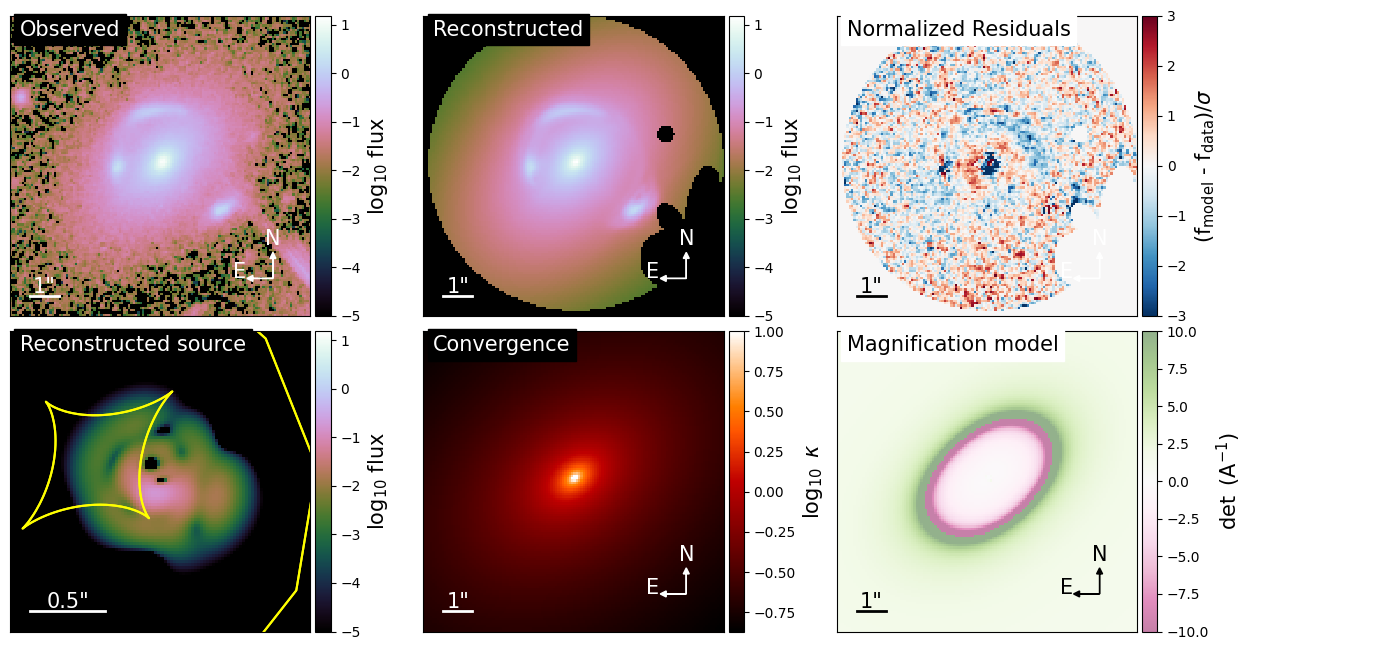

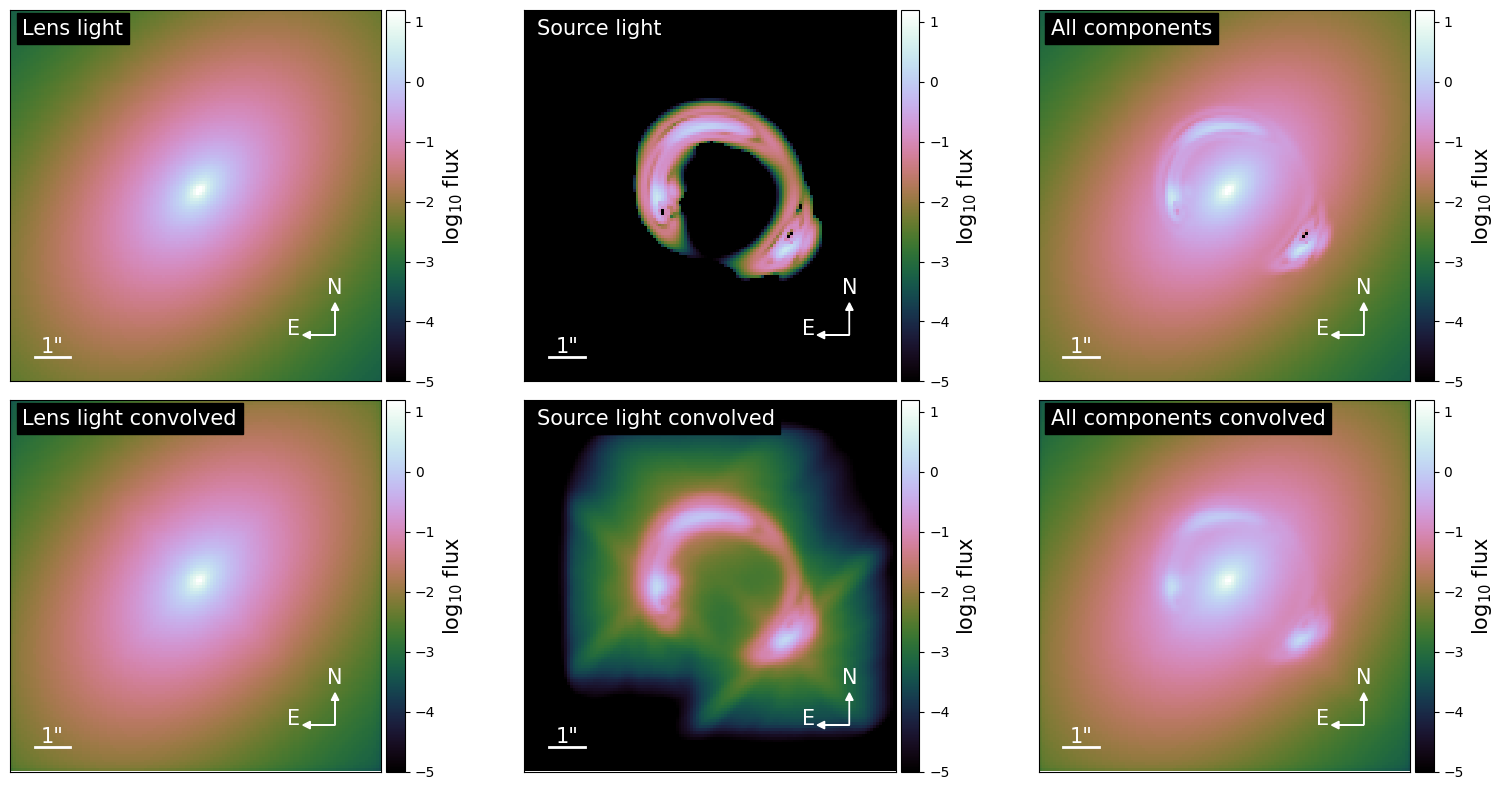

{'kwargs_lens': [{'theta_E': 2.0054753496856197, 'gamma': 1.9273072840502439, 'e1': 0.05323676983716294, 'e2': -0.18052766621741628, 'center_x': 0.030459015541836474, 'center_y': 0.05482078399222124}, {'gamma1': 0.021895992937713618, 'gamma2': 0.019861792193288756, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': -103.39243696178792, 'R_sersic': 0.09095861632036682, 'n_sersic': 1.0, 'e1': 0.28786465670151373, 'e2': -0.10834530330007426, 'center_x': -0.38914347505481606, 'center_y': -0.08612780795172813}, {'amp': array([ 657.27716566,   44.98028373, -259.33532194,   24.47194759,
        -35.17694777,  -80.36287248,  -26.6360782 ,   36.46593906,
        -17.79902723,  111.60069912,   38.78332228,   45.08354097,
         21.04702689,   36.92576164,   40.09683071,   -6.93115897,
        -10.08799499,   -4.39671124,  -28.73066291,    8.59817915,
        -64.50776378,   15.28472888,  -26.48737404,    4.85264125,
        -27.04110733,    5.04337539,  -24.24574938,    5.68133679,
        -17

In [ ]:
model_plot = ModelPlot(
    multi_band_list,
    kwargs_model,
    kwargs_result,
    arrow_size=0.02,
    cmap_string="cubehelix",
    image_likelihood_mask_list=kwargs_likelihood["image_likelihood_mask_list"],
)

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.data_plot(ax=axes[0, 0])
model_plot.model_plot(ax=axes[0, 1])
model_plot.normalized_residual_plot(ax=axes[0, 2], v_min=-3, v_max=3, cmap="RdBu_r")
model_plot.source_plot(
    ax=axes[1, 0], deltaPix_source=0.02, with_caustics=True, scale_size=0.5, numPix=100
)
model_plot.convergence_plot(ax=axes[1, 1], v_max=1, cmap="gist_heat")
model_plot.magnification_plot(ax=axes[1, 2], cmap="PiYG")
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.decomposition_plot(
    ax=axes[0, 0], text="Lens light", lens_light_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 0], text="Lens light convolved", lens_light_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 1], text="Source light", source_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 1], text="Source light convolved", source_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 2],
    text="All components",
    source_add=True,
    lens_light_add=True,
    unconvolved=True,
)
model_plot.decomposition_plot(
    ax=axes[1, 2],
    text="All components convolved",
    source_add=True,
    lens_light_add=True,
    point_source_add=True,
)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()
print(kwargs_result)

## Model Fitting using MCMC

In [20]:
# Define the local path to save the backend file:

local_backend_path = "/content/drive/MyDrive/mcmc_backend.h5"

fitting_kwargs_list_mcmc = [
    [
        "MCMC",
        {
            "n_burn": 0,
            "n_run": 3,
            "n_walkers": 200,
            "sigma_scale": 0.1,
            "threadCount": 3,
            "backend_filename": local_backend_path,
            "start_from_backend": True,
        },
    ]
]

chain_list_mcmc = fitting_seq.fit_sequence(fitting_kwargs_list_mcmc)
kwargs_result_mcmc = fitting_seq.best_fit()

100%|██████████| 3/3 [01:38<00:00, 32.84s/it]


Computing the MCMC...
Number of walkers =  200
Burn-in iterations:  0
Sampling iterations (in current run): 3
102.9302408695221 time taken for MCMC sampling


### Trace Plots

<ipython-input-21-ab48d1d40357>:16: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if not samples_mcmc == []:


N_step: 2134, N_walkers: 200, N_params: 20
theta_E_lens0 2.0289 ± 0.0044
gamma_lens0 1.8507 ± 0.0160
e1_lens0 0.0599 ± 0.0036
e2_lens0 -0.2110 ± 0.0082
center_x_lens0 0.0429 ± 0.0053
center_y_lens0 0.0654 ± 0.0035
gamma1_lens1 0.0284 ± 0.0023
gamma2_lens1 -0.0121 ± 0.0050
R_sersic_source_light0 0.0842 ± 0.0075
e1_source_light0 0.3762 ± 0.0506
e2_source_light0 0.0249 ± 0.0527
center_x_source_light0 -0.3612 ± 0.0084
center_y_source_light0 -0.0791 ± 0.0042
beta_source_light1 0.1138 ± 0.0024
R_sersic_lens_light0 1.8073 ± 0.0129
e1_lens_light0 -0.0112 ± 0.0014
e2_lens_light0 -0.2259 ± 0.0014
center_x_lens_light0 -0.0071 ± 0.0004
center_y_lens_light0 0.0497 ± 0.0007
R_sersic_lens_light1 0.6116 ± 0.0088


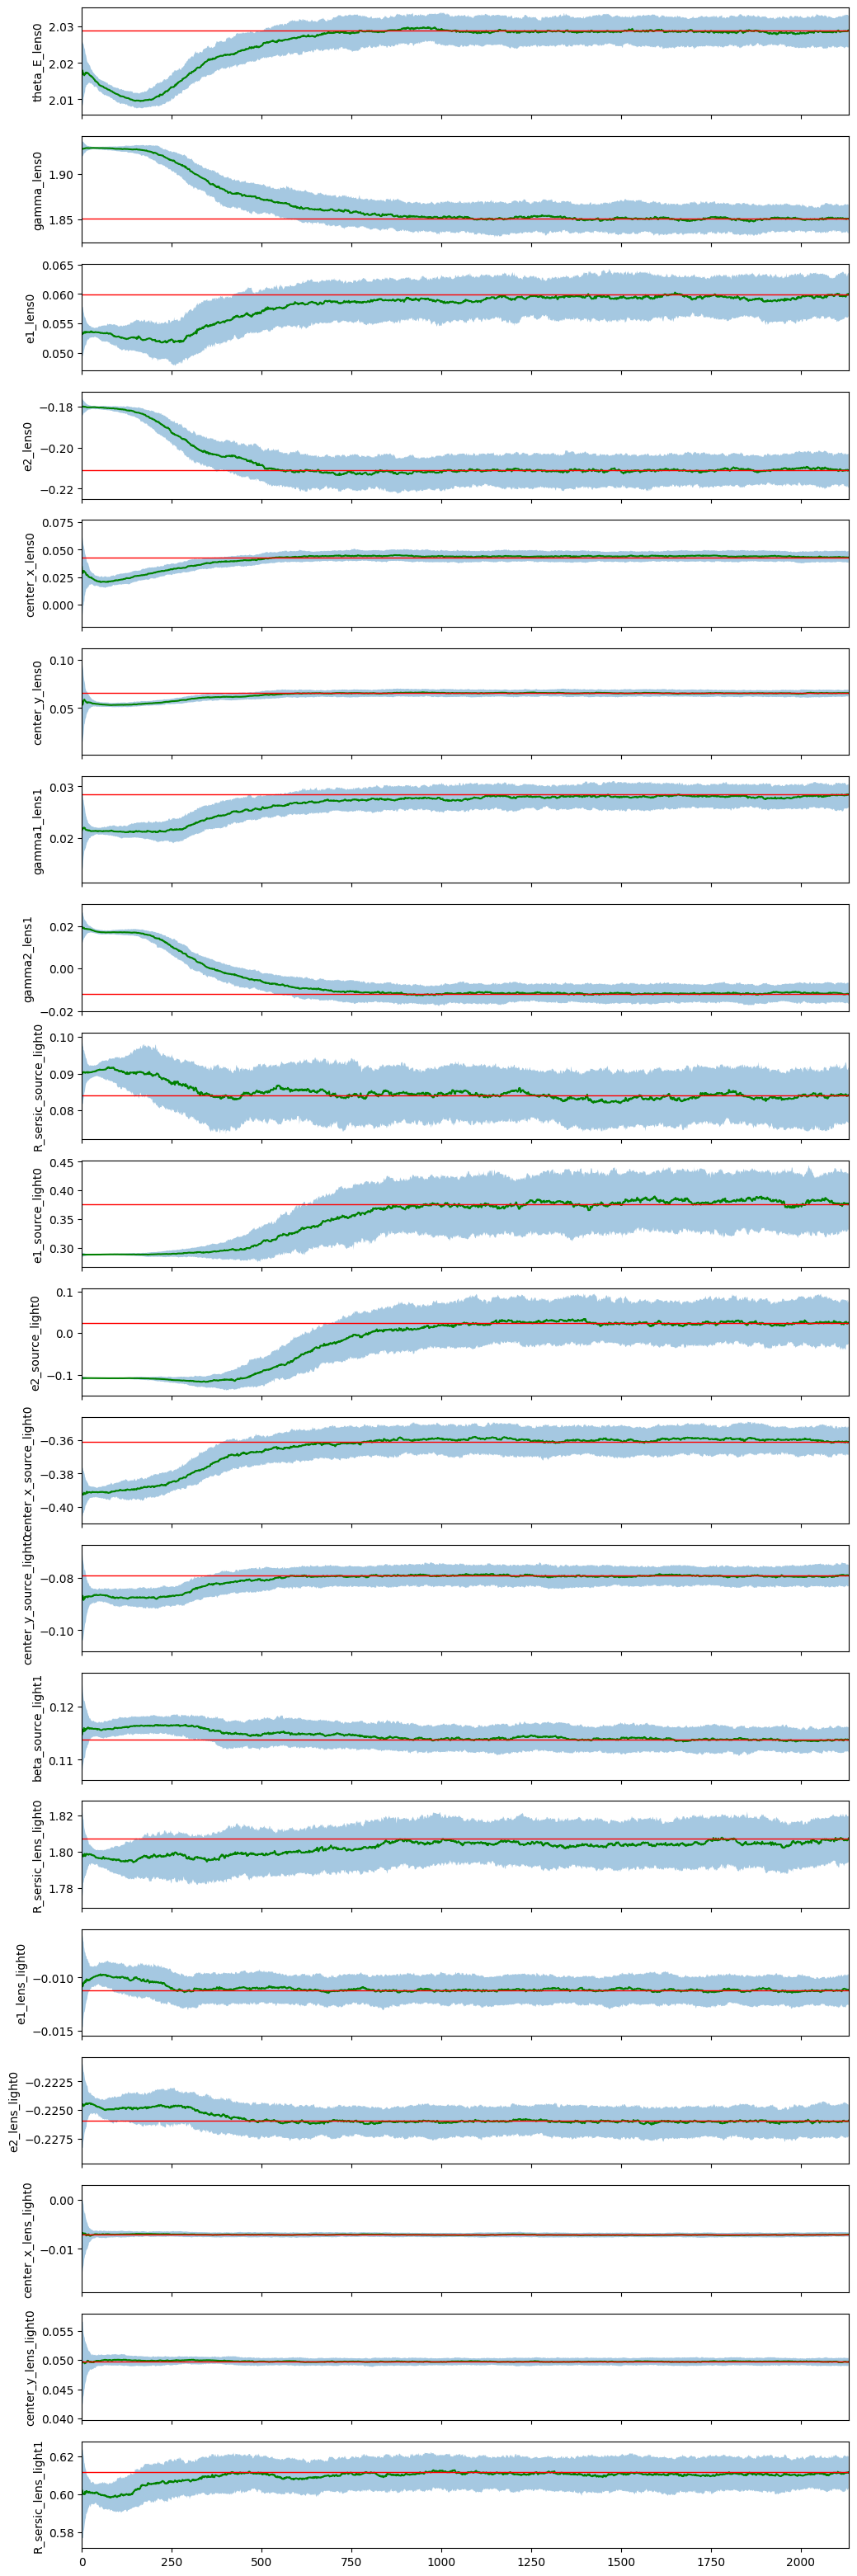

In [21]:
samples_mcmc = []

if chain_list_mcmc[-1][0] != "PSO":
    # if MCMC chain was broken in the chunks,
    # we join the chunks to make the full chain
    mcmc_repeat = 1

    for k in range(len(chain_list_mcmc) - mcmc_repeat, len(chain_list_mcmc)):
        if samples_mcmc == []:
            samples_mcmc = chain_list_mcmc[k][1]
        else:
            samples_mcmc = np.vstack((samples_mcmc, chain_list_mcmc[k][1]))

        param_mcmc = chain_list_mcmc[k][2]

if not samples_mcmc == []:
    n_params = samples_mcmc.shape[1]
    n_walkers = 200
    n_step = int(samples_mcmc.shape[0] / n_walkers)
    n_burn = 0

    print("N_step: {}, N_walkers: {}, N_params: {}".format(n_step, n_walkers, n_params))

    chain = np.empty((n_walkers, n_step, n_params))

    for i in range(n_params):
        samples = samples_mcmc[:, i]
        reshaped_samples = samples.reshape((n_walkers, n_step), order="F")
        chain[:, :, i] = reshaped_samples

    mean_pos = np.zeros((n_params, n_step))
    median_pos = np.zeros((n_params, n_step))
    std_pos = np.zeros((n_params, n_step))
    q16_pos = np.zeros((n_params, n_step))
    q84_pos = np.zeros((n_params, n_step))

    for i in range(n_params):
        for j in range(n_step):
            mean_pos[i][j] = np.mean(chain[:, j, i])
            median_pos[i][j] = np.median(chain[:, j, i])
            std_pos[i][j] = np.std(chain[:, j, i])
            q16_pos[i][j] = np.percentile(chain[:, j, i], 16.0)
            q84_pos[i][j] = np.percentile(chain[:, j, i], 84.0)

    fig, ax = plt.subplots(n_params, sharex=True, figsize=(8, 6))

    burnin = -1
    last = n_step

    medians = []

    param_values = [
        median_pos[0][last - 1],
        (q84_pos[0][last - 1] - q16_pos[0][last - 1]) / 2,
        median_pos[1][last - 1],
        (q84_pos[1][last - 1] - q16_pos[1][last - 1]) / 2,
    ]

    for i in range(n_params):
        print(
            param_mcmc[i],
            "{:.4f} ± {:.4f}".format(
                median_pos[i][last - 1],
                (q84_pos[i][last - 1] - q16_pos[i][last - 1]) / 2,
            ),
        )

        ax[i].plot(median_pos[i][:last], c="g")
        ax[i].axhline(np.median(median_pos[i][burnin:last]), c="r", lw=1)
        ax[i].fill_between(
            np.arange(last), q84_pos[i][:last], q16_pos[i][:last], alpha=0.4
        )

        ax[i].set_ylabel(param_mcmc[i], fontsize=10)
        ax[i].set_xlim(0, last)

        medians.append(np.median(median_pos[i][burnin:last]))
    if True:
        fig.set_size_inches((12.0, 2 * len(param_mcmc)))
        plt.show()

### Corner Plots

Number of non-linear parameters in the MCMC process: 20
Parameters in order: ['theta_E_lens0', 'gamma_lens0', 'e1_lens0', 'e2_lens0', 'center_x_lens0', 'center_y_lens0', 'gamma1_lens1', 'gamma2_lens1', 'R_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'center_x_source_light0', 'center_y_source_light0', 'beta_source_light1', 'R_sersic_lens_light0', 'e1_lens_light0', 'e2_lens_light0', 'center_x_lens_light0', 'center_y_lens_light0', 'R_sersic_lens_light1']
Number of evaluations in the MCMC process: 426800
426800
Shape of samples_mcmc_cut: (18800, 20)


<ipython-input-22-e4f2dc2417c7>:15: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if not samples_mcmc_cut == []:


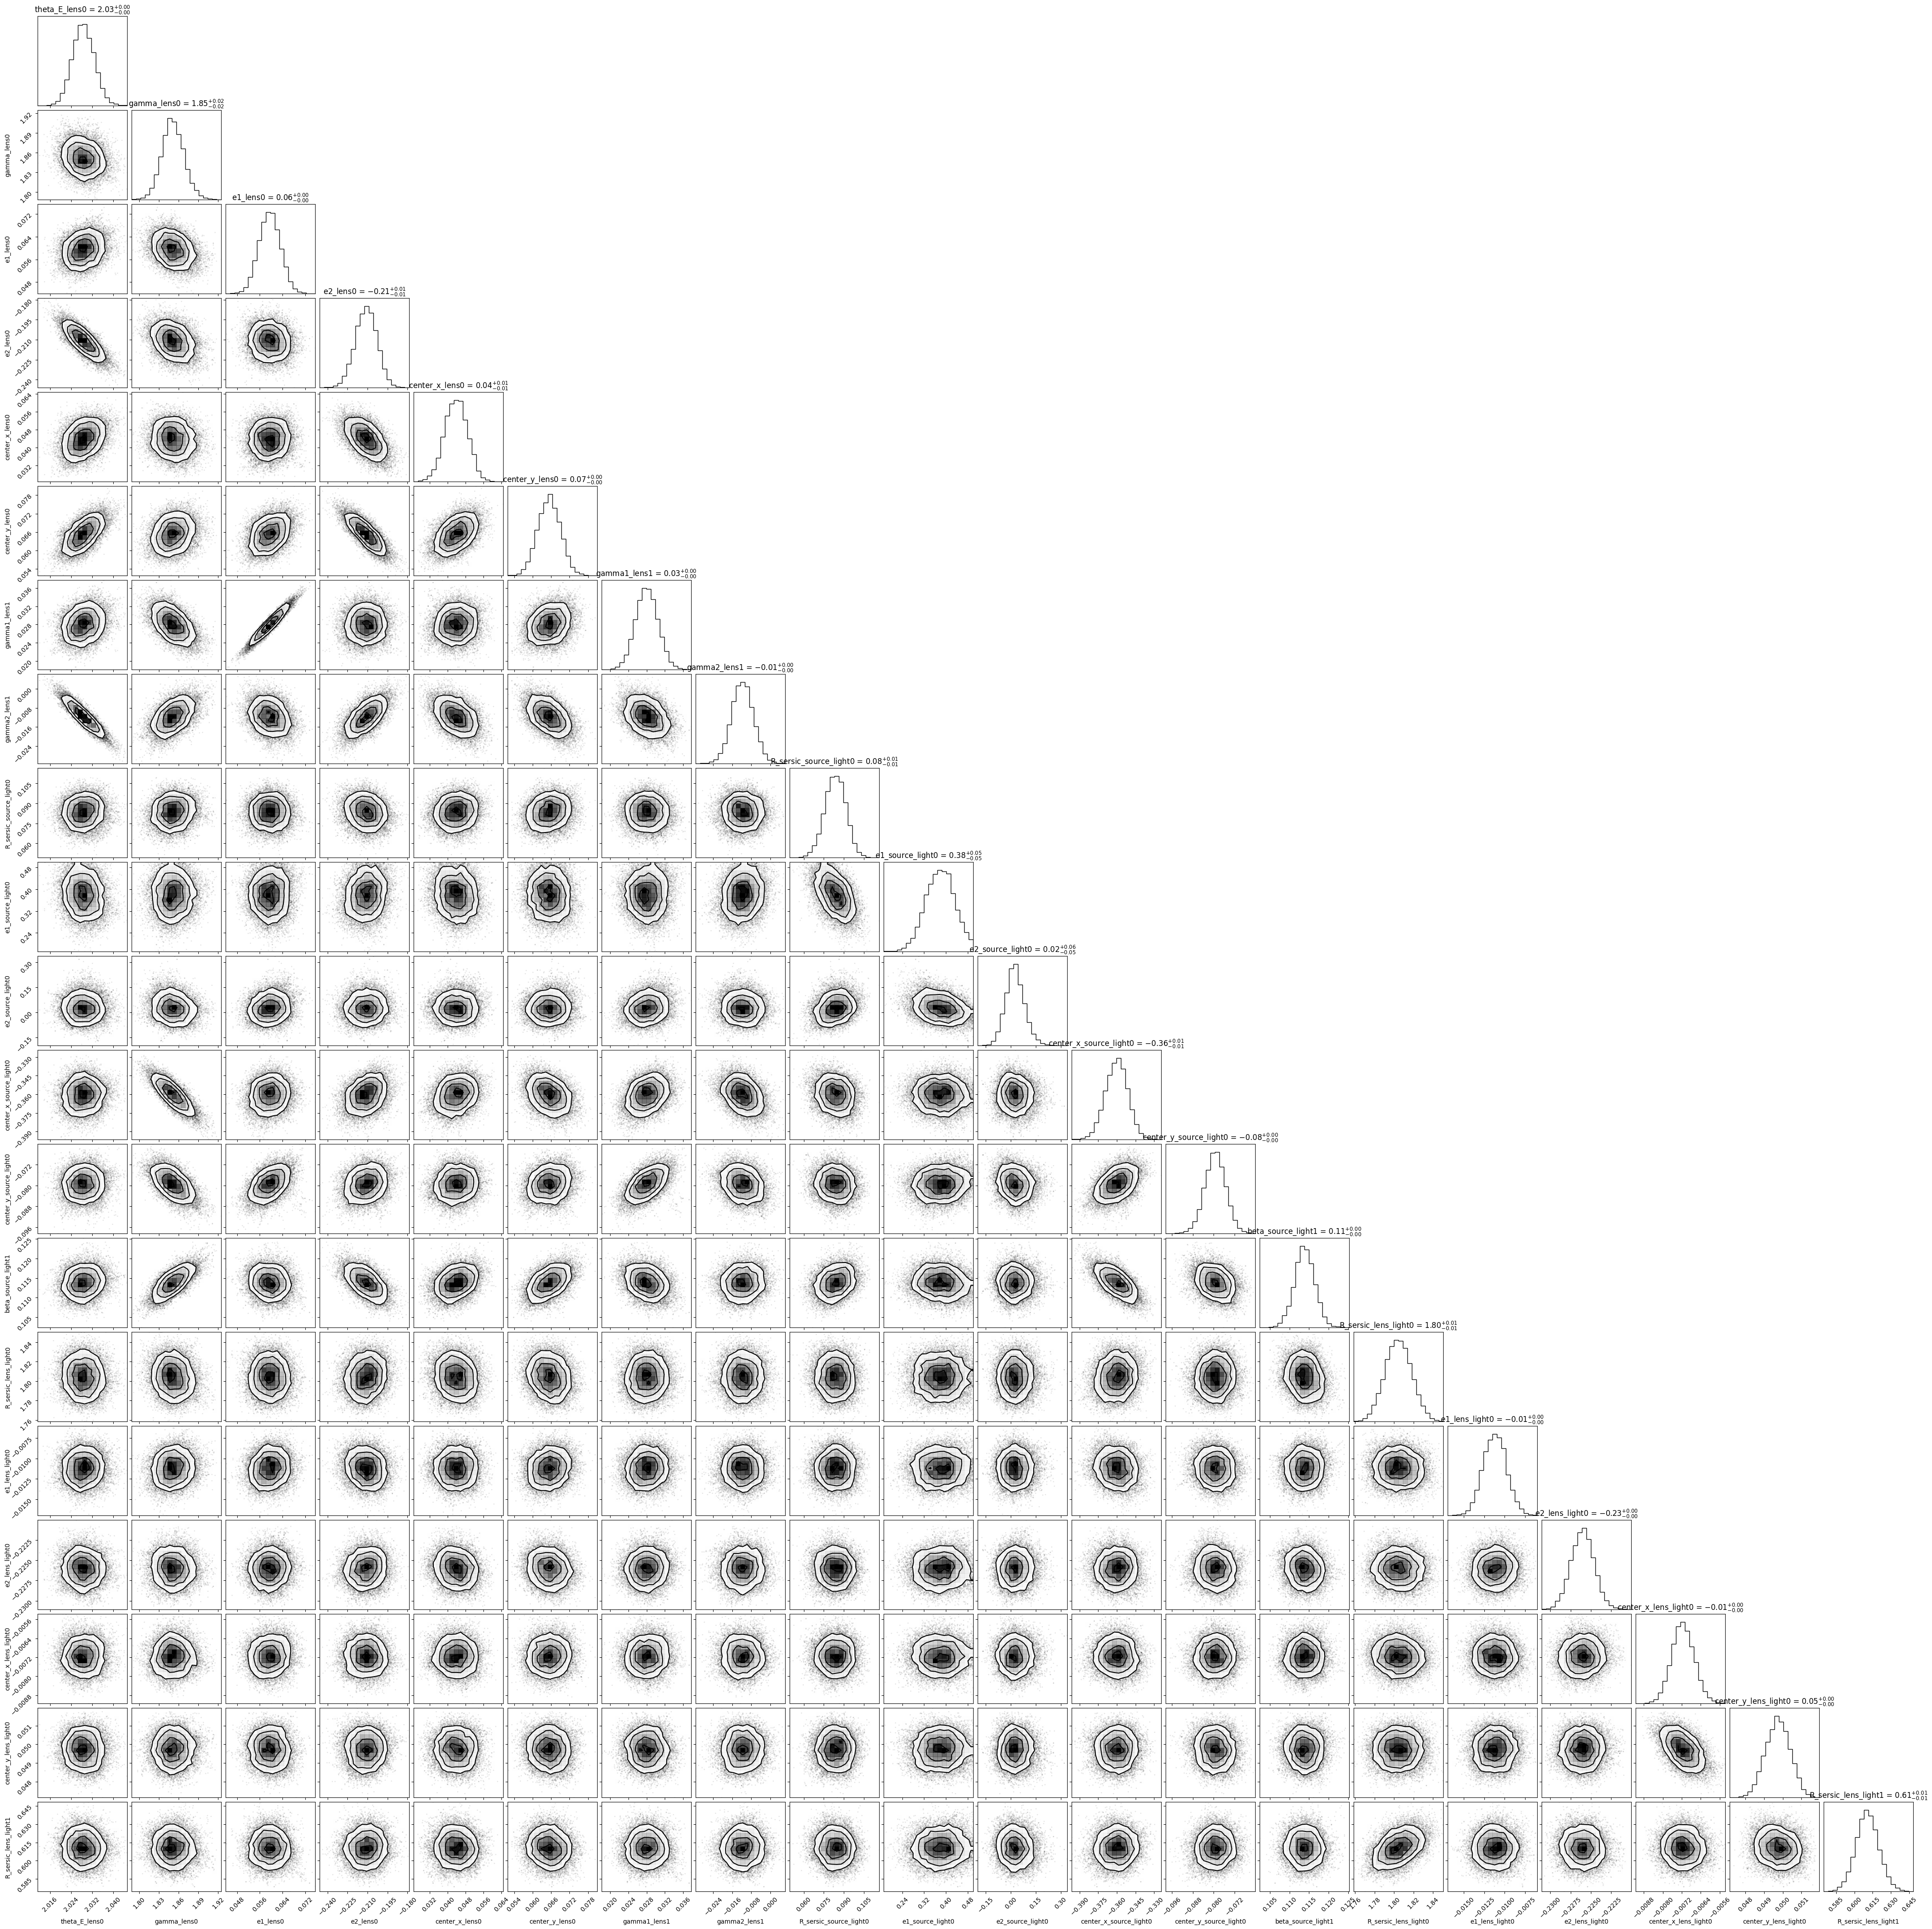

In [22]:
if len(chain_list_mcmc) > 0:
    sampler_type, samples_mcmc, param_mcmc, dist_mcmc = chain_list_mcmc[0]

    param_class = fitting_seq.param_class

    print("Number of non-linear parameters in the MCMC process:", len(param_mcmc))
    print("Parameters in order:", param_mcmc)
    if samples_mcmc is not None:
        print("Number of evaluations in the MCMC process:", np.shape(samples_mcmc)[0])
        n_sample = len(samples_mcmc)
        print(n_sample)
        burnin = 1200
        thin = 10
        samples_mcmc_cut = chain[:, burnin::thin, :].reshape((-1, n_params))
        if not samples_mcmc_cut == []:
            n, num_param = np.shape(samples_mcmc_cut)
            print("Shape of samples_mcmc_cut:", samples_mcmc_cut.shape)
            plot = corner.corner(samples_mcmc_cut, labels=param_mcmc, show_titles=True)
    else:
        print("No samples available for corner plot.")
else:
    print("No MCMC chains available.")

## Visualizing the Fitted Model (MCMC)

-0.9414195801591682 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  0.9414195801591664


/usr/local/lib/python3.10/dist-packages/lenstronomy/Plots/model_band_plot.py:63: RuntimeWarning: divide by zero encountered in log10
  log_model = np.log10(model)
/usr/local/lib/python3.10/dist-packages/lenstronomy/Plots/model_band_plot.py:148: RuntimeWarning: invalid value encountered in log10
  np.log10(self._data),
/usr/local/lib/python3.10/dist-packages/lenstronomy/Plots/model_band_plot.py:211: RuntimeWarning: divide by zero encountered in log10
  np.log10(self._model),
<ipython-input-23-35b6919701c9>:20: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


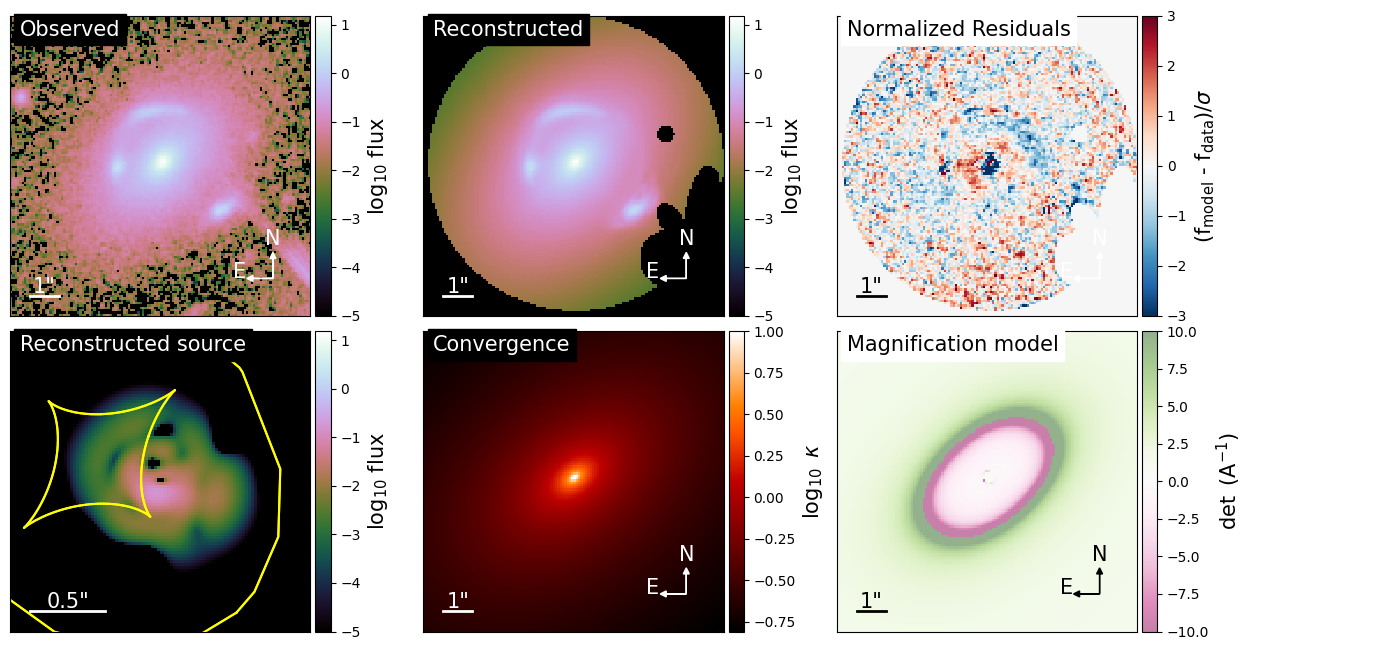

/usr/local/lib/python3.10/dist-packages/lenstronomy/Plots/model_band_plot.py:1062: RuntimeWarning: invalid value encountered in log10
  np.log10(model),


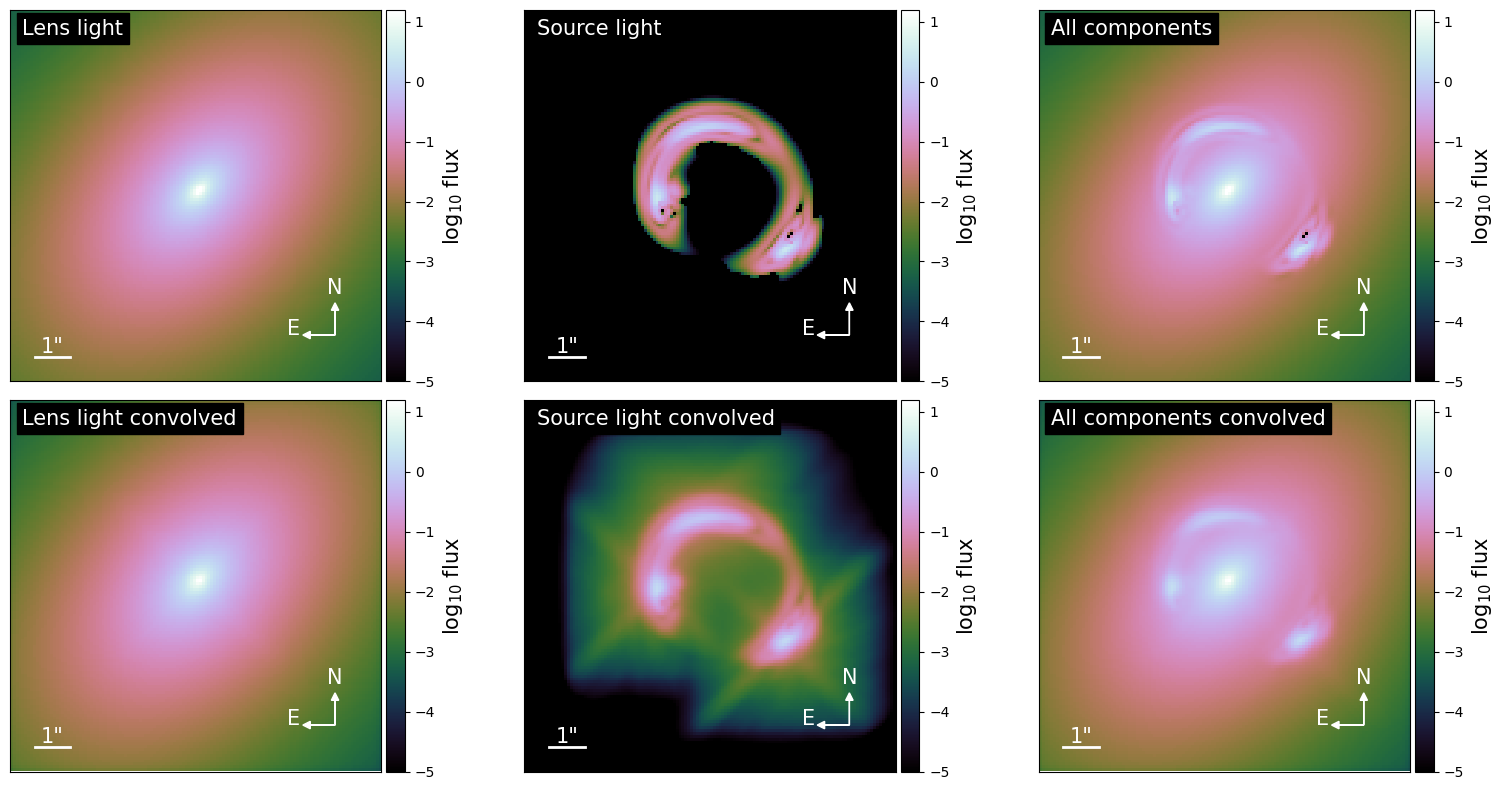

{'kwargs_lens': [{'theta_E': 2.02808851933693, 'gamma': 1.8587447353475455, 'e1': 0.05931638015917028, 'e2': -0.21260558886194142, 'center_x': 0.043860593786592544, 'center_y': 0.06652159229337495}, {'gamma1': 0.027469575237607714, 'gamma2': -0.01067351232568067, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': -95.17580642463062, 'R_sersic': 0.08615467424872325, 'n_sersic': 1.0, 'e1': 0.3656228146293372, 'e2': -0.004028309328075814, 'center_x': -0.3610388486828029, 'center_y': -0.07946452460547125}, {'amp': array([ 6.02987531e+02,  3.44869068e+01, -2.41176985e+02,  1.26727566e+01,
       -1.86799930e+00, -8.46019619e+01, -2.65803670e+01,  4.48306681e+01,
       -1.99102687e+01,  1.08479230e+02,  3.83267610e+01,  3.59394502e+01,
        1.41090843e+01,  1.62610952e+01,  4.42309598e+01, -3.71308451e+00,
       -2.02590292e+01, -5.66030627e-01, -3.42468865e+01,  1.17823118e+01,
       -6.24277694e+01,  1.14972754e+01, -1.98062045e+01,  8.87587602e+00,
       -2.10410959e+01,  8.3206412

In [23]:
model_plot = ModelPlot(
    multi_band_list,
    kwargs_model,
    kwargs_result_mcmc,
    arrow_size=0.02,
    cmap_string="cubehelix",
    image_likelihood_mask_list=kwargs_likelihood["image_likelihood_mask_list"],
)

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.data_plot(ax=axes[0, 0])
model_plot.model_plot(ax=axes[0, 1])
model_plot.normalized_residual_plot(ax=axes[0, 2], v_min=-3, v_max=3, cmap="RdBu_r")
model_plot.source_plot(
    ax=axes[1, 0], deltaPix_source=0.02, numPix=100, with_caustics=True, scale_size=0.5
)
model_plot.convergence_plot(ax=axes[1, 1], v_max=1, cmap="gist_heat")
model_plot.magnification_plot(ax=axes[1, 2], cmap="PiYG")
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()
f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.decomposition_plot(
    ax=axes[0, 0], text="Lens light", lens_light_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 0], text="Lens light convolved", lens_light_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 1], text="Source light", source_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 1], text="Source light convolved", source_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 2],
    text="All components",
    source_add=True,
    lens_light_add=True,
    unconvolved=True,
)
model_plot.decomposition_plot(
    ax=axes[1, 2],
    text="All components convolved",
    source_add=True,
    lens_light_add=True,
    point_source_add=True,
)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()
print(kwargs_result_mcmc)

## Mass and Light Ellipticity of the Lens Galaxy


In [24]:
result_mass_e1 = kwargs_result_mcmc["kwargs_lens"][0]["e1"]
result_mass_e2 = kwargs_result_mcmc["kwargs_lens"][0]["e2"]

result_light_e1 = kwargs_result_mcmc["kwargs_lens_light"][0]["e1"]
result_light_e2 = kwargs_result_mcmc["kwargs_lens_light"][0]["e2"]

mass_phi, mass_q = ellipticity2phi_q(result_mass_e1, result_mass_e2)
light_phi, light_q = ellipticity2phi_q(result_light_e1, result_light_e2)

print(
    "mass_q: {},\nlight_q: {}".format(
        mass_q,
        light_q,
    )
)

mass_q: 0.6383705073997756,
light_q: 0.6304930598313557


### Save the Best Fit Parameters (MCMC)

In [26]:
multi_band_list_out = fitting_seq.multi_band_list
kwargs_fixed_out = fitting_seq.kwargs_fixed

init_samples = n_step  # cannot be 'None' for MCMC

input = [
    fitting_kwargs_list_mcmc,
    multi_band_list,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
    init_samples,
]

output = [kwargs_result_mcmc, multi_band_list_out, kwargs_fixed_out]

output_path = "/content/DESIJ1709+3154_mcmc_output.joblib"

with open(output_path, "wb") as f:
    joblib.dump([input, output], f, compress=True)